In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
data = pd.read_csv('data/character-predictions_pose.csv')
# data = pd.read_csv('../character-predictions_pose.csv')
def clean(characters):
    # selected columns I think might be relevant
    characters = characters.loc[:,['name', 'male', 'house', 'isNoble', 'numDeadRelations', 'popularity', 'isAlive', 'culture', 'boolDeadRelations', 'isPopular']]
    # deleted all observations that have NaNs
    characters = characters[~characters.isnull().any(axis=1)]
    characters.reset_index(inplace = True, drop = True)
    
    # clean cultures 

    culture_counts = pd.DataFrame(characters.culture.value_counts())

    #combining culture names that mean the same thing 
    characters.culture = characters.culture.replace(to_replace = "northmen", value = "Northmen")
    characters.culture = characters.culture.replace(to_replace = "ironborn", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Ironmen", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Asshai'i", value = "Asshai")
    characters.culture = characters.culture.replace(to_replace = "Free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "Summer Islands", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "Summer Islander", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "westermen", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerman", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerlands", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Vale", value = "Valemen")
    characters.culture = characters.culture.replace(to_replace = "Lhazareen", value = "Lhazarene")
    characters.culture = characters.culture.replace(to_replace = "The Reach", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Reachmen", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Qarth", value = "Qartheen")
    characters.culture = characters.culture.replace(to_replace = "Lyseni", value = "Lysene")
    characters.culture = characters.culture.replace(to_replace = "Stormlander", value = "Stormlands")
    characters.culture = characters.culture.replace(to_replace = "Meereenese", value = "Meereen")
    characters.culture = characters.culture.replace(to_replace = "Astapor", value = "Astapori")
    characters.culture = characters.culture.replace(to_replace = "Norvos", value = "Norvoshi")
    characters.culture = characters.culture.replace(to_replace = "Wildlings", value = "Wildling")
    characters.culture = characters.culture.replace(to_replace = "Andals", value = "Andal")
    characters.culture = characters.culture.replace(to_replace = "Braavos", value = "Braavosi")
    characters.culture = characters.culture.replace(to_replace = "Dorne", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Dornishmen", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Ghiscaricari", value = "Ghiscari")

    #getting survival rates per culture 
    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    survival_counts = pd.DataFrame(characters.groupby(['culture']).isAlive.value_counts())
    survival_counts.rename({'isAlive':'count_survived'}, axis='columns', inplace=True)
    survival_counts = pd.DataFrame(survival_counts.to_records())
    #for Qohor and Astapori, no one survived — this will be taken into account later and for now they will be dropped
    survival_counts = survival_counts[survival_counts['isAlive'] == 1] 
    survival_counts.drop(columns=["isAlive"], inplace=True)
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "total"})
    survival_df = culture_counts.merge(survival_counts)
    survival_df['percent_survived'] = (survival_df['count_survived']/survival_df['total'])*100
    survival_df = survival_df.sort_values(by=['percent_survived'], ascending=False)

    #grouping cultures based on their survival rates
    characters.culture = characters.culture.replace(to_replace = ['Ibbenese', 'Asshai', 'Lhazarene', 'Summer Isles', 'First Men', 'Naathi', 'Norvoshi', 'Rhoynar', 'Crannogmen'], value = "all_survive")
    characters.culture = characters.culture.replace(to_replace = ['Ironborn', 'Ghiscari', 'Vale mountain clans', 'Dornish', 'Reach'], value = "most_survive")
    characters.culture = characters.culture.replace(to_replace = ['Dothraki', 'Stormlands', 'Rivermen', 'Braavosi', 'Northmen'], value = "many_survive")
    characters.culture = characters.culture.replace(to_replace = ['Qartheen', 'Myrish', 'Lysene', 'Valemen', 'Northern mountain clans', 'Tyroshi', 'Westeros'], value = "morethanhalf_survive")
    characters.culture = characters.culture.replace(to_replace = ['Westermen', 'Riverlands', 'Pentoshi', 'Free Folk', 'Sistermen', 'Meereen'], value = "half_survive")
    characters.culture = characters.culture.replace(to_replace = ['Riverlands', 'Lysene', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Wildling', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Astapori', 'Qohor'], value = "none_survive")



    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "count"})
    display(culture_counts)
    
    
    for house in characters.house:

        percent_alive = characters[characters.house == house].isAlive.mean()

        characters.loc[characters.house == house, 'house_alive'] = percent_alive



    # Bin house_alive into 5 bins

    binned_house_alive = pd.qcut(characters['house_alive'],10,retbins=True, duplicates = 'drop')

    bins = binned_house_alive[1]

    characters['house_alive_binned'] = pd.cut(characters['house_alive'],bins = bins)

    dum = pd.get_dummies(characters.house_alive_binned,drop_first = True)

    dum.columns = ['house_alive'+str(x) for x in range(1,len(bins)-1)]

    characters = pd.concat([characters,dum], axis = 1)

 

    age_data = characters.groupby('house_alive_binned')['isAlive'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)

    # sns.lineplot(x = age_data.index, y= age_data['percent'])

    # plt.xlabel('house_bin')
    
    return characters
characters = clean(data)
characters

,culture,count
0,most_survive,186
1,many_survive,167
2,morethanhalf_survive,49
3,few_survive,44
4,half_survive,29
5,all_survive,15
6,none_survive,3


,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


In [5]:
def bin_opp(num):
    return 1 if num==0 else 0

In [29]:
def test_person(name, formula, data = characters):
    train = data.loc[data['name'] != name]
    person = data.loc[data['name'] == name]
    model = sm.logit(formula = formula, data=data).fit(disp=0, method='bfgs')
    prediction = model.predict(person)
    return prediction.values[0], person["isAlive"].values[0]

In [30]:
def test(formula, num_examples=50, loss_func=None, cutoff=.3, clean_data=characters):
    accurate_counter = 0
    mat_state = [[0,0],[0,0]]
    for index, row in clean_data.iterrows():
        p, act = test_person(row['name'], formula, data = clean_data)
        if p + cutoff >= 1:
            bin_p = 1
        else:
            bin_p = 0
        mat_state[bin_opp(bin_p)][bin_opp(act)] += 1
        if index >= num_examples:
            break
    if loss_func is None:
        return mat_state[0][0]+mat_state[1][1], mat_state
    else:
        return loss_func(accurate_counter), mat_state

In [9]:
X = characters[['male', 'house_alive_binned', 'isNoble', 'numDeadRelations', 'popularity', 'culture', 'boolDeadRelations', 'isPopular']]
Xy = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["house"])
X = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive","house_alive"])

In [10]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = Xy).fit()
    # accuracy = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5, clean_data=Xy)[0]
    # accuracy /= len(characters)
    accuracy = model.llf
    return {"model":model, "accuracy":accuracy}

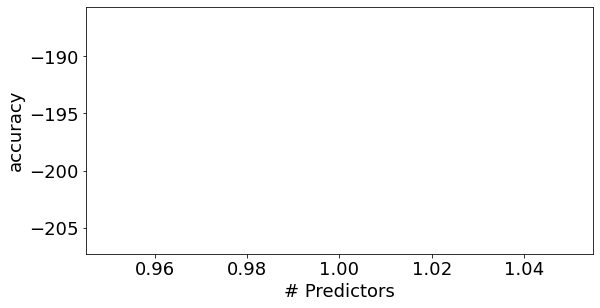

In [13]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('accuracy')

best_sub_plots()

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [15]:
#Filtering all predictors
X = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive","house_alive"])
y = characters["isAlive"]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

alphas = 10**np.linspace(0,-2.5,200)*0.5

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

#Note that we are reducing the range of alpha so as to better visualize the minimum
# alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 100, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
# pred1=lasso.predict(Xtest1_std)
pd.Series(lasso.coef_, X.columns)

numDeadRelations                     1.216357e-02
popularity                           4.903688e-02
house_alive1                         2.064663e-02
house_alive2                         1.470222e-02
house_alive3                         6.181844e-02
house_alive4                         3.292120e-02
house_alive5                         9.324133e-02
house_alive6                         4.974765e-02
house_alive7                         2.285401e-01
male_0                               3.004304e-02
male_1                              -0.000000e+00
house_alive_binned_(0.0, 0.31]       8.604597e-02
house_alive_binned_(0.31, 0.5]       7.978782e-02
house_alive_binned_(0.5, 0.571]      2.757647e-02
house_alive_binned_(0.571, 0.717]    1.255632e-01
house_alive_binned_(0.717, 0.75]     4.504024e-02
house_alive_binned_(0.75, 0.833]     1.231514e-01
house_alive_binned_(0.833, 0.87]     6.084962e-02
house_alive_binned_(0.87, 1.0]       1.264579e-01
isNoble_0                           -6.446569e-03


In [16]:
lasso.predict(X)

array([0.87808214, 0.9008597 , 0.77151201, 1.11745758, 0.97934437,
       0.99211166, 1.11729358, 0.87289287, 0.98377245, 1.12685621,
       0.77456886, 0.88566807, 1.00274943, 0.89813477, 0.98049239,
       0.989071  , 0.9811484 , 0.83867733, 1.0087314 , 0.88017941,
       0.75255152, 0.7987078 , 0.76712359, 0.80215186, 1.12439616,
       0.9813124 , 0.96567668, 0.99206374, 1.11778559, 1.160056  ,
       1.14700862, 0.99124373, 1.14733662, 1.00823939, 0.83966135,
       0.98082039, 0.87656356, 0.99178366, 1.11696558, 0.97934437,
       0.99112764, 1.11778559, 0.81908684, 0.98049239, 0.87488086,
       1.11762159, 1.14750063, 0.99145565, 1.14684462, 0.99161965,
       1.0088954 , 0.97934437, 0.97955629, 1.11762159, 0.97918036,
       0.98180441, 0.99161965, 0.98049239, 0.88397222, 0.81794969,
       0.9612486 , 1.0085674 , 0.89930414, 0.87561344, 0.87104512,
       0.76505669, 0.79509973, 0.76505669, 0.75861012, 0.96223262,
       0.73840688, 0.94967725, 0.77292883, 1.15509522, 0.76997

In [63]:
characters
# X = X.drop(columns="Intercept")
characters

,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


In [91]:
culture = characters.culture
house_alive_binned = characters.house_alive_binned
characters = pd.get_dummies(characters, columns=["culture"])

isAlive~male
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
isAlive~isNoble
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
isAlive~numDeadRelations
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
isAlive~popularity
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
isAlive~boolDeadRelations
Optimization terminated successfully.
         Current function value: 0.597315
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
isAlive~isPopular
Optimization terminated su

         Current function value: 0.484319
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                                model    accuracy
0   <statsmodels.discrete.discrete_model.BinaryRes...  486.046749
1   <statsmodels.discrete.discrete_model.BinaryRes...  484.290319
2   <statsmodels.discrete.discrete_model.BinaryRes...  486.529172
3   <statsmodels.discrete.discrete_model.BinaryRes...  488.682146
4   <statsmodels.discrete.discrete_model.BinaryRes...  485.741010
5   <statsmodels.discrete.discrete_model.BinaryRes...  488.691504
6   <statsmodels.discrete.discrete_model.BinaryRes...  485.711731
7   <statsmodels.discrete.discrete_model.BinaryRes...  488.692196
8   <statsmodels.discrete.discrete_model.BinaryRes...  481.216505
9   <statsmodels.discrete.discrete_model.BinaryRes...  487.019993
10  <statsmodels.discrete.discrete_model.BinaryRes...  464.430870
11  <statsmodels.discrete.discrete_model.BinaryRes...  483.242726
12  <sta

         Current function value: 0.431222
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive6
Optimization terminated successfully.
         Current function value: 0.427406
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32
isAlive~house_alive7+culture_few_survive+house_alive5+culture_all_survive
         Current function value: 0.427442
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+culture_half_survive
         Current function value: 0.431192
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+culture_many_survive
         Current function value: 0.429225
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
i

         Current function value: 0.414910
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_many_survive
         Current function value: 0.413772
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_morethanhalf_survive
         Current function value: 0.412518
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_most_survive
         Current function value: 0.415486
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_none_survive
         Current function value: 0.413036
         I

isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+culture_none_survive
         Current function value: 0.400778
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                                model    accuracy
0   <statsmodels.discrete.discrete_model.BinaryRes...  414.854865
1   <statsmodels.discrete.discrete_model.BinaryRes...  414.995042
2   <statsmodels.discrete.discrete_model.BinaryRes...  413.798695
3   <statsmodels.discrete.discrete_model.BinaryRes...  413.771209
4   <statsmodels.discrete.discrete_model.BinaryRes...  414.383818
5   <statsmodels.discrete.discrete_model.BinaryRes...  413.876617
6   <statsmodels.discrete.discrete_model.BinaryRes...  414.107781
7   <statsmodels.discrete.discrete_model.BinaryRes...  411.465748
8   <statsmodels.discrete.discrete_model.BinaryRes...  414.709273
9   <statsmodels.discrete.discrete_model.BinaryRes...  412.901030
10  <statsmode

isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive
         Current function value: 0.393170
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_morethanhalf_survive
         Current function value: 0.394907
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_most_survive
         Current function value: 0.398343
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+cul

         Current function value: 0.390669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_half_survive
         Current function value: 0.392720
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_morethanhalf_survive
         Current function value: 0.392852
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_most_survive
         Current function value:

         Current function value: 0.389342
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_none_survive+boolDeadRelations+culture_most_survive
         Current function value: 0.391632
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                               model    accuracy
0  <statsmodels.discrete.discrete_model.BinaryRes...  412.834201
1  <statsmodels.discrete.discrete_model.BinaryRes...  410.820968
2  <statsmodels.discrete.discrete_model.BinaryRes...  408.857154
3  <statsmodels.discrete.discrete_model.BinaryRes...  411.714958
4  <statsmodels.discrete.discrete_model.BinaryRes...  413.014216
5  <statsmodels.discrete.discrete_model.BinaryRes...  413.891030
6  <statsmodels.discrete.discrete_model.BinaryRes...

         Current function value: 0.386319
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                               model    accuracy
0  <statsmodels.discrete.discrete_model.BinaryRes...  414.759360
1  <statsmodels.discrete.discrete_model.BinaryRes...  414.848905
2  <statsmodels.discrete.discrete_model.BinaryRes...  414.352170
3  <statsmodels.discrete.discrete_model.BinaryRes...  416.910699
Processed  4 models on 17 predictors in 0.10205793380737305 seconds.
isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_none_survive+boolDeadRelations+popularity+numDeadRelations+isPopular+culture_morethanhalf_survive+isNoble
         Current function value: 0.384735
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
isAlive~house_alive7+culture_few_survive+house_alive5+house

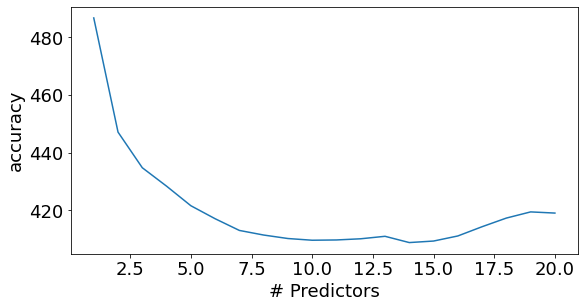

In [86]:
from sklearn.linear_model import LogisticRegression

# X = characters.drop(columns=["name","house","isAlive","house_alive_binned","house_alive","culture","house_alive1","house_alive2","house_alive3","house_alive4","house_alive5","house_alive6"])
# X_backup = characters.drop(columns=["name","house","isAlive","house_alive_binned","house_alive","culture","house_alive1","house_alive2","house_alive3","house_alive4","house_alive5","house_alive6"])
new_characters = characters
X = new_characters.drop(columns=["name","isAlive","house_alive_binned","house_alive","house"])
X_backup = new_characters.drop(columns=["name","isAlive","house_alive_binned","house_alive","house"])


#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = characters).fit(method='bfgs')
    # accuracy = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5, clean_data=Xy)[0]
    # accuracy /= len(characters)
    accuracy = model.aic
    return {"model":model, "accuracy":accuracy}
    
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print(models)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()
best_sub_plots()

In [87]:
models_best.loc[np.argmin(models_best.accuracy),"model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                isAlive   No. Observations:                  493
Model:                          Logit   Df Residuals:                      479
Method:                           MLE   Df Model:                           13
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3642
Time:                        06:37:11   Log-Likelihood:                -191.51
converged:                      False   LL-Null:                       -301.24
Covariance Type:            nonrobust   LLR p-value:                 1.352e-39
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7146      0.453     -1.576      0.115      -1.603       0.174
house_alive7             5.7155      0.956      5.978      0.000       3.842       7.589
culture_few_survive     -0.9728      0.620     -1.570      0.116      -2.187       0.242
house_alive5             2.4000      0.488      4.921      0.000       1.444       3.356
house_alive3             1.7698      0.447      3.961      0.000       0.894       2.645
house_alive6             3.5307      1.029      3.430      0.001       1.513       5.548
culture_all_survive      2.7874      1.404      1.986      0.047       0.036       5.539
male                    -0.5970      0.293     -2.035      0.042      -1.172      -0.022
house_alive4             1.5286      0.748      2.045      0.041       0.063       2.994
house_alive1             0.8911      0.454      1.963      0.050       0.001       1.781
culture_many_survive     0.5520      0.288      1.916      0.055      -0.013       1.117
house_alive2             0.6080      0.868      0.700      0.484      -1.094       2.310
culture_none_survive    -1.7942      2.436     -0.736      0.461      -6.570       2.981
boolDeadRelations       -0.4058      0.309     -1.314      0.189      -1.011       0.200
========================================================================================
"""

In [92]:
characters["culture"] = culture
characters["house_alive_binned"] = house_alive_binned
test(formula="isAlive~house_alive7+culture_few_survive+house_alive5+house_alive3+house_alive6+culture_all_survive+male+house_alive4+house_alive1+culture_many_survive+house_alive2+culture_none_survive+boolDeadRelations+culture*house_alive_binned", clean_data=characters, num_examples=500)

(391, [[278, 35], [67, 113]])

In [93]:
391 / len(characters)

0.7931034482758621

In [95]:
test(formula="isAlive~house_alive_binned", clean_data=characters, num_examples=500)

(357, [[229, 20], [116, 128]])

In [60]:
characters

,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


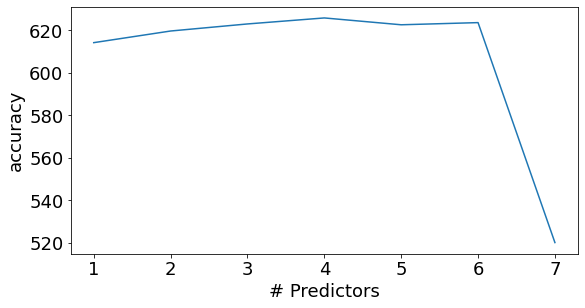

In [44]:
best_sub_plots()

In [20]:
models_best

,accuracy,model
1,614.114469,<statsmodels.discrete.discrete_model.BinaryRes...
2,619.587298,<statsmodels.discrete.discrete_model.BinaryRes...
3,622.908418,<statsmodels.discrete.discrete_model.BinaryRes...
4,625.732361,<statsmodels.discrete.discrete_model.BinaryRes...
5,622.517179,<statsmodels.discrete.discrete_model.BinaryRes...
6,623.534212,<statsmodels.discrete.discrete_model.BinaryRes...
7,520.114814,<statsmodels.discrete.discrete_model.BinaryRes...


In [21]:
models_best.loc[4, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                isAlive   No. Observations:                  493
Model:                          Logit   Df Residuals:                      488
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.01287
Time:                        06:00:07   Log-Likelihood:                -297.36
converged:                       True   LL-Null:                       -301.24
Covariance Type:            nonrobust   LLR p-value:                    0.1011
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3508      0.217      6.218      0.000       0.925       1.777
isPopular      0.1983      0.614      0.323      0.747      -1.006       1.402
popularity    -0.5016      0.912     -0.550      0.582      -2.290       1.286
isNoble       -0.3078      0.211     -1.458      0.145      -0.722       0.106
male          -0.4059      0.224     -1.812      0.070      -0.845       0.033
==============================================================================
"""

In [24]:
test(formula="isAlive~isPopular+popularity+isNoble+male+culture+house_alive_binned", clean_data=characters, num_examples=500)

(381, [[263, 30], [82, 118]])

In [31]:
test(formula="isAlive~culture+house_alive_binned+culture*house_alive_binned", clean_data=characters, num_examples=500)

(389, [[283, 42], [62, 106]])

In [25]:
'''
from sklearn.linear_model import LogisticRegression

characters["Intercept"] = 1
X = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])
X_backup = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])

def forward_model_selection(df):

    # Create a list of all features except the target variable
    features = X

    # Create an empty list to store the selected features
    selected_features = []

    # Create a baseline model with only the intercept
    # model = LogisticRegression().fit(df[['Intercept']], df["isAlive"])

    # Calculate the baseline score
    baseline_score, throwaway = test(formula="isAlive~1", clean_data=characters, num_examples=500, cutoff=.5)

    # Loop over the features and select the best one at each iteration
    while not features.empty:
        best_score = -1
        best_feature = None

        # Loop over the remaining features and find the one with the highest score
        for feature in features:
            
            formula = "isAlive~" + "+".join(selected_features) + "+" + feature

            # Calculate the score for the new model
            score, throwaway = test(formula=formula, clean_data=characters, num_examples=500, cutoff=.5)

            # If the score is better than the previous best score, update the best score and feature
            if score > best_score:
                best_score = score
                best_feature = feature

        # Add the best feature to the selected features list and remove it from the features list
        selected_features.append(best_feature)
        print(selected_features)
        features.drop(columns=best_feature)

        # If the new score is worse than the baseline score, stop the selection process
        if best_score <= baseline_score:
            break
            
        baseline_score = best_score

    return selected_features

forward_model_selection(characters)
'''

ValueError: mismatch between column_names and columns coded by given terms